`02_pandas2.ipynb`

## Grouping

In [ ]:
import pandas as pd
import numpy as np

# 샘플 데이터: 온라인 쇼핑몰 주문 데이터
data = {
    '주문번호': [1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010],
    '고객ID': ['A', 'B', 'A', 'C', 'B', 'A', 'D', 'C', 'B', 'D'],
    '상품카테고리': ['전자제품', '의류', '가구', '전자제품', '의류', '식품', '가구', '식품', '전자제품', '의류'],
    '구매액': [150000, 75000, 220000, 95000, 82000, 45000, 180000, 35000, 120000, 62000],
    '배송지역': ['서울', '부산', '서울', '인천', '서울', '부산', '인천', '서울', '부산', '인천'],
    '할인률': [0.05, 0.1, 0, 0.2, 0.1, 0, 0.05, 0.15, 0.2, 0]
}

df = pd.DataFrame(data)

In [ ]:
# 기본 그룹 - 고객별 구매액 총합
df.groupby('고객ID')['구매액'].sum()

# 그룹 객체
id_group = df.groupby('고객ID')

# 그룹확인 (고객 ID들 그룹)
id_group.groups.keys()

# 특정 그룹 데이터 확인
id_group.get_group('A')

# 여러 Col으로 그루핑 (Series)
multi_group = df.groupby(['고객ID', '상품카테고리'])['구매액'].sum()
# DF 변환
multi_group.to_frame()

# 1개 col(구매액)에 집계함수 여러개 적용
df.groupby('고객ID')['구매액'].agg(['sum', 'mean', 'count', 'min', 'max'])

# n개 col에 m개 집계함수
df.groupby('고객ID').agg({
    '구매액': ['sum', 'mean', 'count'],
    '할인률': ['mean', 'max']
})


# 사용자 정의 집계 함수
def discount_amount(price):
    return (price * df.loc[price.index, '할인률']).sum()

df.groupby('고객ID')['구매액'].agg([
    # AS, function
    ('총구매액', 'sum'),
    ('평균구매액', 'mean'),
    ('할인총액', discount_amount),
])

In [ ]:
# 집계 함수 응용
import pandas as pd
import numpy as np

# 샘플 데이터
df = pd.DataFrame({
    '상품ID': ['A001', 'A002', 'A001', 'A003', 'A002', 'A004', 'A003', 'A001', 'A002', 'A004'],
    '판매일자': pd.date_range('2023-01-01', periods=10),
    '판매수량': [5, 3, 7, 2, 4, 6, 3, 8, 5, 4],
    '판매금액': [50000, 30000, 70000, 25000, 40000, 65000, 30000, 80000, 50000, 45000],
    '반품수량': [0, 1, 0, 0, 0, 2, 1, 0, 0, 1],
    '고객평점': [4.5, 3.8, 4.2, 5.0, 4.0, 3.5, 4.2, 4.8, 3.9, 4.1]
})

In [ ]:
# 기본 집계
df.groupby('상품ID').agg({
    '판매수량': ['sum', 'mean', 'count'],
    '판매금액': ['sum', 'mean'],
    '반품수량': ['sum'],
    '고객평점': ['mean']
})

df

In [ ]:
# 커스텀 함수
# 총 판매수량 대비 반품수량 비율
def return_rate(x):
    # print(x, type(x))
    total_sold = df.loc[x.index, '판매수량'].sum()
    total_returned = df.loc[x.index, '반품수량'].sum()
    return total_returned / total_sold if total_sold > 0 else 0

df.groupby('상품ID').agg({
    '판매수량': ['sum', 'count'],
    '반품수량': ['sum', return_rate],
})

In [ ]:
# 그룹별 순위 및 누적 계산
import pandas as pd
import numpy as np

# 샘플 데이터: 부서별 직원 실적
data = {
    '직원ID': [101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112],
    '이름': ['김철수', '이영희', '박민수', '정지영', '최동민', '강준호', '윤서연', '임태혁', '한미래', '송지원', '오민지', '홍길동'],
    '부서': ['영업', '개발', '영업', '인사', '개발', '영업', '개발', '인사', '영업', '개발', '영업', '인사'],
    '월별실적': [120, 85, 95, 110, 75, 135, 95, 110, 115, 90, 125, 100],
    '고객평가': [4.5, 3.8, 4.2, 4.7, 3.9, 4.8, 4.1, 4.3, 4.5, 4.0, 4.6, 4.2]
}

df = pd.DataFrame(data)
print("부서별 직원 실적 데이터:")
df

In [ ]:
# 그룹 내 순위 계산
dept_group = df.groupby('부서')

# 부서별 월별 실적 랭킹(높은사람부터)
df['부서순위_실적'] = dept_group['월별실적'].rank(method='dense', ascending=False)

# 동일 순위가 있을 경우의 처리 방식
# rank_methods = ['average', 'min', 'max', 'dense', 'first']
# for method in rank_methods:
#     col_name = f'순위_{method}'
#     df[col_name] = df.groupby('부서')['월별실적'].rank(method=method, ascending=False)

# df

df

In [ ]:
1 == 1.0

In [ ]:
# 누적 합계 및 누적 통계
# 부서별 누적 실적 합계  -> acummulate cummulate

df['부서별누적합계'] = df.groupby('부서')['월별실적'].cumsum()
df['부서별누적최대'] = df.groupby('부서')['월별실적'].cummax()

# 그룹별 비율계산
# 부서별 총 실적 대비 개인 실적 비율
df['부서총실적'] = dept_group['월별실적'].transform('sum')
df['부서기여도'] = df['월별실적'] / df['부서총실적']

# 복합응용
# 성과점수는 = 0.7 실적 + 0.3 (평가*20)
df['성과점수'] = df['월별실적'] * 0.7 + df['고객평가'] * 0.3 * 20
# 성과점수 별 랭킹
df['부서순위_성과'] = dept_group['성과점수'].rank(method='dense', ascending=False)

def cal_bonus(row):
    # 10% 기본보너스
    base_bonus = row['월별실적'] * 0.1
    rank = row['부서순위_성과'] 
    if rank == 1:
        return base_bonus * 1.5
    elif rank == 2:
        return base_bonus * 1.3
    elif rank == 3:
        return base_bonus * 1.1
    else:
        return base_bonus

# 랭킹별 보너스 지급 함수
df['성과급'] = df.apply(cal_bonus, axis=1)
df

## 실습: 매출 데이터 그룹별 분석

In [ ]:
# 실습: 매출 데이터 그룹별 분석
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 매출 데이터 생성
np.random.seed(42)

# 날짜 생성 (2023년 전체)
dates = pd.date_range('2023-01-01', '2023-12-31')
n_records = 500

data = {
    '주문ID': np.arange(1001, 1001 + n_records),
    '주문일자': np.random.choice(dates, n_records),
    '고객ID': np.random.choice([f'CUST{i:03d}' for i in range(1, 101)], n_records),
    '상품ID': np.random.choice([f'PROD{i:03d}' for i in range(1, 51)], n_records),
    '카테고리': np.random.choice(['전자제품', '의류', '가구', '식품', '화장품', '도서', '스포츠'], n_records),
    '매출액': np.random.randint(10000, 500000, n_records),
    '수량': np.random.randint(1, 10, n_records),
    '지역': np.random.choice(['서울', '부산', '인천', '대구', '광주', '대전', '울산', '경기', '강원'], n_records),
    '결제방법': np.random.choice(['신용카드', '현금', '체크카드', '휴대폰', '계좌이체'], n_records),
    '고객등급': np.random.choice(['일반', '실버', '골드', 'VIP'], n_records)
}

df = pd.DataFrame(data)

In [ ]:
df.head(3)

In [ ]:
# 검색후 하기
# 날짜 정보 추출 -> 컬럼 추가 ['주문년월', '요일', '주'(1년중 몇번째 주)]
df['주문년월'] = df['주문일자'].dt.strftime('%Y-%m')
df['요일'] = df['주문일자'].dt.day_name()
df['주'] = df['주문일자'].dt.isocalendar().week

# 1/1 인 행들만 확인
df[ df['주문일자'] == '2023-01-01' ]

In [ ]:
# 단가 계산 
# 단가 컬럼 추가 (매출액/수량)
df['단가'] = df['매출액'] / df['수량']

In [ ]:
# 카테고리별 매출 분석 
# 매출액 sum, mean, count / 수량 sum
df.groupby('카테고리').agg({
    '매출액': ['sum', 'mean', 'count'],
    '수량': ['sum']
})

In [ ]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 카테고리별 매출 비중 시각화
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
category_sum = df.groupby('카테고리')['매출액'].sum().sort_values(ascending=False)
category_sum.plot(kind='bar')
plt.title('카테고리별 총매출')
plt.ylabel('총 매출')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
category_sum.plot(kind='pie', autopct='%1.1f%%')
plt.title('카테고리별 매출 비중')
plt.ylabel('')
plt.tight_layout()
plt.show()

In [ ]:
# 월별 매출 트렌드
# '주문년월' 컬럼으로 매출액 sum, 주문ID count, 단가 mean
monthly_sales = df.groupby('주문년월').agg({
    '매출액': 'sum',
    '주문ID': ['count'],
    '단가': 'mean'
}).rename(columns={'주문ID': '주문건수'})

monthly_sales

In [ ]:
plt.figure(figsize=(14, 6))

# 매출액 추이
ax1 = plt.subplot(111)
monthly_sales['매출액'].plot(kind='line', marker='o', ax=ax1, color='blue')
ax1.set_title('월별 매출액 및 주문건수 추이')
ax1.set_ylabel('매출액', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# 주문건수 추이 (보조 축)
ax2 = ax1.twinx()
monthly_sales['주문건수'].plot(kind='line', marker='s', ax=ax2, color='red')
ax2.set_ylabel('주문건수', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.tight_layout()
plt.show()


In [ ]:
# 지역 & 카테고리별 매출 분석

# uunstack -> 다중인덱스 구조를 가로(열)로 펼쳐서 재구조화 함 : Index -> Col
regional_df = df.groupby(['지역', '카테고리'])['매출액'].sum().unstack()
regional_df

In [ ]:
# 히트맵 시각화
plt.figure(figsize=(12, 8))
sns.heatmap(regional_df, cmap='YlGnBu', annot=True, fmt='.0f')
plt.title('지역별, 카테고리별 매출액 히트맵')
plt.tight_layout()
plt.show()

In [ ]:
# 요일별 고객 등급별 매출 패턴

# 요일의 순서 지정
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['요일'] = pd.Categorical(df['요일'], categories=day_order, ordered=True)

day_grade_sales = df.groupby(['요일', '고객등급'])['매출액'].sum().unstack()

# 시각화
plt.figure(figsize=(14, 7))
day_grade_sales.plot(kind='bar', stacked=True)
plt.title('요일별, 고객등급별 매출 구성')
plt.ylabel('매출액')
plt.legend(title='고객등급')
plt.tight_layout()
plt.show()

In [ ]:
# 결제방법별 분석 및 고객 행동 (매출액-sum mean count, 단가-mean)

total_sales = df['매출액'].sum()

def ratio(x):
    return x.sum() / total_sales * 100

payment_stats = df.groupby('결제방법').agg({
    '매출액': ['sum', 'mean', 'count', ratio],
    '단가': ['mean']
})

payment_stats

In [ ]:
# .nunique -> Series에서 고유한 값 개수 / DF 는 모든 컬럼에 고유한 값 개수

In [ ]:
# 고객id 별 구매 패턴 (매출액 sum mean count, 구매한 고유 상품 수, 구매한 고유 카테고리 수)

def get_uniq_count(x):
    return x.nunique()

df.groupby('고객ID').agg({
    '매출액': ['sum', 'mean', 'count'],
    '상품ID': 'nunique',  # 위아래는 같다
    '카테고리': get_uniq_count,
}).sort_values([('매출액', 'sum'), ('상품ID', 'nunique')], ascending=False).head(3)

# sort_values(['a', 'b'])  => ORDER BY a, b => 단일 인덱스 컬럼
# sort_values([('a', 'sum'), ('b')])  => Col 'a', Agg 'sum' 값을 기준으로 정렬

In [ ]:
# 주별 매출 추이
weekly_sales = df.groupby('주')['매출액'].sum()

plt.figure(figsize=(14, 6))
weekly_sales.plot(kind='line', marker='o')
plt.title('2023년 주별 매출 추이')
plt.xlabel('주차')
plt.ylabel('매출액')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:

weekly_sales = df.groupby(['주문년월', '주'])['매출액'].sum().reset_index()
weekly_sales = weekly_sales.sort_values(['주문년월', '주'])

# .pct_change()는 바로 이전 행과의 비율 차이를 계산
# fillna(0)으로 첫 주의 결측치는 0으로 처리 (전주 없으니까 0으로)
weekly_sales['매출증감률'] = weekly_sales['매출액'].pct_change().fillna(0)

weekly_sales

In [ ]:
# 매출 TOP 10 상품

In [ ]:
# 정렬 -> 위 10개
df.groupby('상품ID')['매출액'].sum().sort_values(ascending=False).head(10)

# 애초에 상위 10개만 가져와
top_products = df.groupby('상품ID')['매출액'].sum().nlargest(10)

plt.figure(figsize=(12, 6))
top_products.sort_values().plot(kind='barh')
plt.title('매출 기준 TOP 10 상품')
plt.xlabel('매출액')
plt.tight_layout()
plt.show()

## 데이터 결합
1. 데이터 단순 결합(행 결합)
2. 데이터 병합
3. Index 기준 Join

In [ ]:
# 데이터 결합 기초 (concat) - 행결합 (Col 똑같아야 함)

# 샘플 데이터 생성
# 첫 번째 데이터프레임: 1월 판매 데이터
df1 = pd.DataFrame({
    '상품ID': ['A001', 'A002', 'A003', 'A004', 'A005'],
    '상품명': ['노트북', '스마트폰', '태블릿', '헤드폰', '스피커'],
    '판매량_1월': [10, 20, 15, 30, 25]
})

# 두 번째 데이터프레임: 2월 판매 데이터
df2 = pd.DataFrame({
    '상품ID': ['A001', 'A003', 'A005', 'A006', 'A007'],
    '상품명': ['노트북', '태블릿', '스피커', '마우스', '키보드'],
    '판매량_2월': [12, 18, 23, 15, 19]
})

# 기본 concat - 행 결합 -> 안맞는 컬럼은 NaN
pd.concat([df1, df2])

# 인덱스 초기화 (겹치는 인덱스 없이 처음부터 다시)
pd.concat([df1, df2], ignore_index=True)

# 열 방향 결합
pd.concat([df1, df2], axis=1)

# join inner (공통 열만 유지)
pd.concat([df1, df2], join='inner')

In [ ]:
# 데이터 병합 (merge)

products = pd.DataFrame({
    '상품ID': ['P001', 'P002', 'P003', 'P004', 'P005'],
    '상품명': ['노트북', '스마트폰', '태블릿', '헤드폰', '스피커'],
    '가격': [1200000, 850000, 500000, 150000, 75000],
    '카테고리': ['컴퓨터', '모바일', '모바일', '음향기기', '음향기기']
})

orders = pd.DataFrame({
    '주문번호': [1001, 1002, 1003, 1004, 1005, 1006],
    '고객ID': ['C001', 'C002', 'C003', 'C001', 'C004', 'C002'],
    '상품ID': ['P001', 'P002', 'P003', 'P002', 'P005', 'P006'],
    '수량': [1, 2, 1, 1, 3, 2],
    '주문일자': ['2023-01-05', '2023-01-10', '2023-01-15', '2023-01-20', '2023-01-25', '2023-01-30']
})


print(products)
print(orders)
# 기본 병합 (Inner Join)
pd.merge(orders, products, on='상품ID')

# Outer Join
pd.merge(orders, products, on='상품ID', how='outer')

# Left Join
pd.merge(orders, products, on='상품ID', how='left')

# Right Join
pd.merge(orders, products, on='상품ID', how='right')

In [ ]:
customers = pd.DataFrame({
    'ID': ['C001', 'C002', 'C003', 'C004', 'C005'],
    '이름': ['김철수', '이영희', '박민수', '정지영', '최동민'],
    '등급': ['VIP', '골드', '실버', '골드', '브론즈']
})

# 열 이름이 다르면?
pd.merge(
    orders, 
    customers, 
    left_on='고객ID',  # orders 데이터프레임의 열 이름
    right_on='ID',    # customers 데이터프레임의 열 이름
    how='inner'
)

In [ ]:
import pandas as pd
import numpy as np

# 샘플 데이터셋 생성
# 1. 고객 정보 데이터
customers = pd.DataFrame({
    '고객ID': [f'CUST{i:03d}' for i in range(1, 11)],
    '이름': ['김철수', '이영희', '박민수', '정지영', '최동민', '강준호', '윤서연', '임태혁', '한미래', '송지원'],
    '성별': ['남', '여', '남', '여', '남', '남', '여', '남', '여', '여'],
    '연령대': ['30대', '20대', '40대', '30대', '50대', '20대', '40대', '30대', '20대', '50대'],
    '가입일자': pd.date_range('2023-01-01', periods=10, freq='3D'),
    '지역': ['서울', '부산', '서울', '인천', '대구', '서울', '부산', '인천', '서울', '대구']
})

# 2. 주문 정보 데이터
np.random.seed(42)
n_orders = 50

orders = pd.DataFrame({
    '주문번호': [f'ORD{i:04d}' for i in range(1, n_orders+1)],
    '고객ID': np.random.choice(customers['고객ID'], n_orders),
    '주문일자': pd.date_range('2023-01-05', periods=n_orders, freq='2D'),
    '결제방법': np.random.choice(['신용카드', '체크카드', '계좌이체', '간편결제'], n_orders),
    '배송상태': np.random.choice(['배송완료', '배송중', '주문확인', '배송지연'], n_orders, p=[0.7, 0.15, 0.1, 0.05])
})

# 3. 주문 상세 정보 데이터
n_details = 80
products = ['노트북', '스마트폰', '태블릿', '헤드폰', '스피커', '키보드', '마우스', '모니터']
categories = ['전자제품', '컴퓨터', '주변기기', '음향기기']

order_details = pd.DataFrame({
    '상세번호': [f'ITEM{i:04d}' for i in range(1, n_details+1)],
    '주문번호': np.random.choice(orders['주문번호'], n_details),
    '상품명': np.random.choice(products, n_details),
    '카테고리': np.random.choice(categories, n_details),
    '수량': np.random.randint(1, 5, n_details),
    '가격': np.random.choice([50000, 100000, 150000, 800000, 1200000, 1500000], n_details),
    '할인율': np.random.choice([0, 0.1, 0.2, 0.3], n_details)
})

# 4. 배송 정보 데이터
shipping = pd.DataFrame({
    '주문번호': orders['주문번호'].unique(),
    '배송사': np.random.choice(['A택배', 'B물류', 'C익스프레스'], len(orders['주문번호'].unique())),
    '배송비': np.random.choice([0, 2500, 5000], len(orders['주문번호'].unique())),
    '출고일자': pd.date_range('2023-01-06', periods=len(orders['주문번호'].unique()), freq='2D')
})

# 5. 고객 만족도 데이터 (일부 주문에 대해서만)
satisfaction_orders = np.random.choice(orders['주문번호'], size=30, replace=False)
satisfaction = pd.DataFrame({
    '주문번호': satisfaction_orders,
    '만족도': np.random.randint(1, 6, 30),
    '리뷰': np.random.choice(['긍정', '중립', '부정'], 30, p=[0.6, 0.3, 0.1]),
    '리뷰일자': pd.date_range('2023-01-15', periods=30, freq='3D')
})


In [ ]:
customers.head()

In [ ]:
orders.head()

In [ ]:
order_details.head()

In [ ]:
shipping.head()

In [ ]:
satisfaction.head()

In [ ]:
# 주문 - 주문상세  (합친다 - 테이블A, 테이블B)
pd.merge(orders, order_details, on='주문번호', how='inner').head()

In [ ]:
# 테이블A에 합친다 - 테이블B
orders.merge(order_details, on='주문번호', how='inner').head()

In [ ]:
# order_details 에서 총금액 -> group -> orders 에 총 주문금액 추가

# 1. 총 주문금액 계산 - 수량 * 가격 * (1-할인율)
total_series = order_details['수량'] * order_details['가격'] * (1 - order_details['할인율'])
order_details['총금액'] = total_series

# 2. 주문별 합계 계산 -> order_totals DF 생성
order_totals = order_details.groupby('주문번호')['총금액'].sum().reset_index()
order_totals

# 3. orders 와 order_totals 결합 -> 원래 없던 컬럼 추가
order_with_totals = orders.merge(order_totals, on='주문번호', how='left')

order_with_totals.head()

In [ ]:
# 중복된 데이터들 모아서 보기
order_details[order_details.duplicated(subset=['주문번호'], keep=False)].sort_values('주문번호')

In [ ]:
# 주문 데이터에 사용자 병합
orders_customers = order_with_totals.merge(customers, on='고객ID')
orders_customers.head()

In [ ]:
# 배송정보 추가
full_orders = orders_customers.merge(shipping, on='주문번호')
full_orders.head()

# 배송 소요일 추가  (timedelta -> int)
full_orders['배송소요일'] = (full_orders['출고일자'] - full_orders['주문일자']).dt.days

full_orders

In [ ]:
# 만족도 정보 결합
with_satisfaction = full_orders.merge(satisfaction, on='주문번호', how='left')
with_satisfaction.head()

In [150]:
# 분석: 연령대별, 성별 총 주문 금액
spending_stat = with_satisfaction.groupby(['연령대', '성별'])['총금액'].agg(
    ['sum', 'mean', 'count']
).reset_index()

spending_stat

,연령대,성별,sum,mean,count
0,20대,남,4550000.0,1.516667e+06,3
1,20대,여,26820000.0,3.352500e+06,8
2,30대,남,15555000.0,2.592500e+06,6
3,30대,여,16140000.0,4.035000e+06,4
4,40대,남,20675000.0,6.891667e+06,3
5,40대,여,27220000.0,4.536667e+06,6
6,50대,남,7270000.0,1.817500e+06,4
7,50대,여,18780000.0,6.260000e+06,3


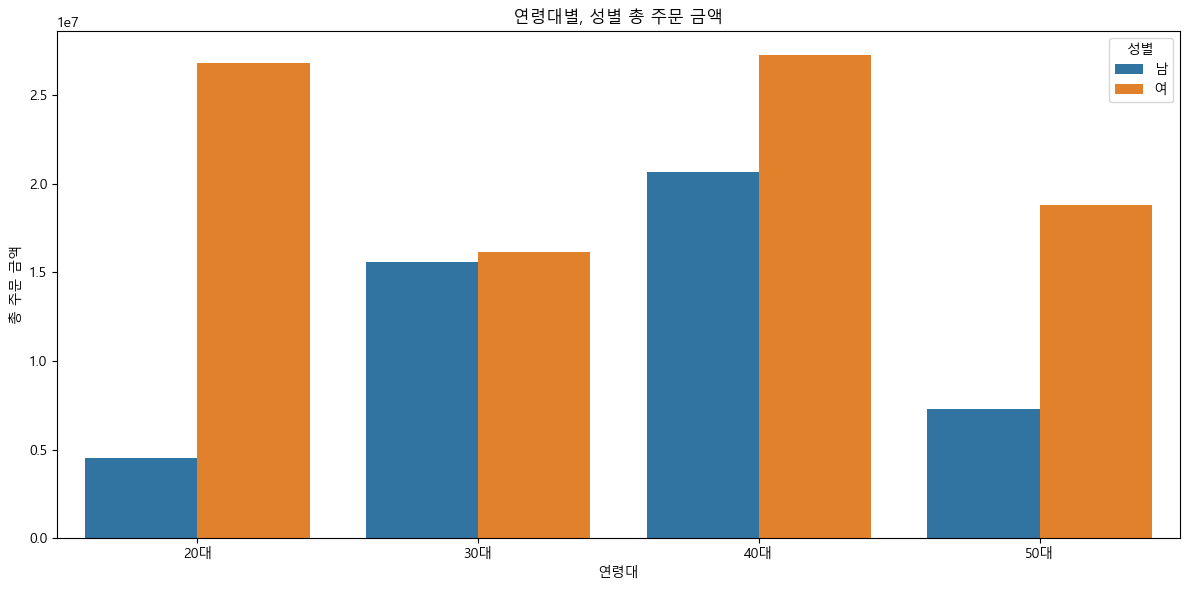

In [154]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore', category=UserWarning)

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(12, 6))
sns.barplot(x='연령대', y='sum', hue='성별', data=spending_stat)
plt.title('연령대별, 성별 총 주문 금액')
plt.ylabel('총 주문 금액')
plt.tight_layout()
plt.show()


In [158]:
# 분석: 결제방법별 평균 주문금액 및 건수
payment_analysis = with_satisfaction.groupby('결제방법').agg({
    '총금액': ['mean', 'sum', 'count']
}).reset_index()

payment_analysis

결제방법           총금액                  
                 mean         sum count
0  간편결제  3.911111e+06  35200000.0     9
1  계좌이체  3.934000e+06  19670000.0     5
2  신용카드  3.605000e+06  32445000.0     9
3  체크카드  3.549643e+06  49695000.0    14

In [163]:
# 만족도와 총 주문 금액 관계

# 결측치 제거
order_sati = with_satisfaction.dropna(subset=['만족도'])

# 만족도별 평균 주문 금액
sati_spend = order_sati.groupby('만족도')['총금액'].mean().reset_index()
sati_spend

,만족도,총금액
0,1.0,4.000000e+05
1,2.0,7.275000e+05
2,3.0,1.266667e+06
3,4.0,5.803333e+06
4,5.0,3.610000e+06


In [175]:
# 지역별 배송사 선호
# with_satisfaction.groupby(['지역', '배송사'])['주문번호'].count()  # 아래랑 결과 같음
region_shipping = with_satisfaction.groupby(['지역', '배송사']).size().unstack().fillna(0)
region_shipping

배송사,A택배,B물류,C익스프레스
지역,,,
대구,5.0,4.0,3.0
부산,7.0,1.0,4.0
서울,8.0,0.0,7.0
인천,4.0,3.0,4.0


<Figure size 1200x600 with 0 Axes>

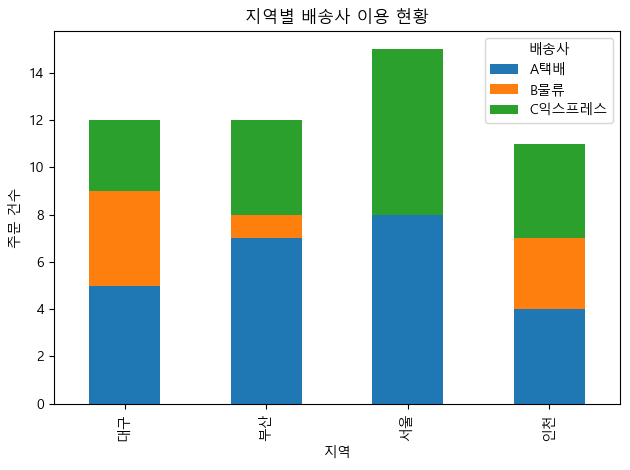

In [176]:
plt.figure(figsize=(12, 6))
region_shipping.plot(kind='bar', stacked=True)
plt.title('지역별 배송사 이용 현황')
plt.ylabel('주문 건수')
plt.legend(title='배송사')
plt.tight_layout()
plt.show()